In [1]:
import numpy as np
from math import exp
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkContext
from pyspark import SparkConf

conf = SparkConf().setAppName("data_stream")
sc = SparkContext(conf=conf)

In [3]:
P = 123457
delta = exp(-5)
epsilon = exp(10**(-4))
n_buckets = 10**4
hash_params = [list(map(int, line.strip().split('\t'))) for line in open('hash_params.txt')]
n_hashes = len(hash_params)

## Main algorithm

In [10]:
# your code here
buckets = np.zeros((n_hashes, n_buckets))

In [5]:
# your code here
# hash function

# Returns hash(x) for hash function given by parameters a, b, p and n buckets 
def hash_func(a,b,p,n,x):
    a = int(a)
    b = int(b)
    x = int(x)
    y = x % p
    val = (a*y + b)%p
    return val % n

def hash_x(x, p, n, params):
    hash_l = []
    for idx, l in enumerate(params):
        a,b = l
        val = hash_func(a,b, p, n, x)
        hash_l.append((idx,val))
    return hash_l

In [6]:
# read steaming data
data = sc.textFile('data_stream.txt')

In [7]:
# count hash value
hash_count = data.flatMap(lambda x: hash_x(x,P, n_buckets,hash_params)).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

In [27]:
for k,v in hash_count.collect():
    nh, nb = k
    buckets[nh][nb] = v

## Compare the exact and approximate counts

In [29]:
# read the exact counts
exact_counts = defaultdict(int)
with open('counts.txt') as f:
    for line in f:
        key, value = line.strip().split('\t')
        exact_counts[int(key)] = int(value)

In [30]:
# to do
# get approximate count of each sample
approx_counts = defaultdict(int)
# your code here
for k, v in exact_counts.items():
    hash_k = hash_x(k,P, n_buckets,hash_params)
    approx_val = min(buckets[h] for h in hash_k)
    approx_counts[k] = approx_val
  

"""
Log-log plot of the relative error as a function of the frequency
"""

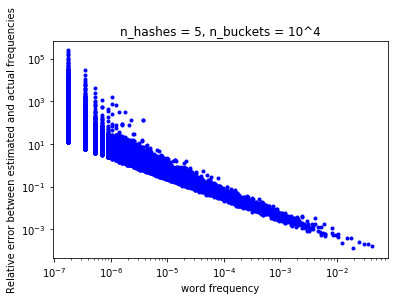

<Figure size 432x288 with 0 Axes>

In [35]:
def plot_error_hist(exact_freq,error,n_hashes,n_buckets):    
    plt.hist(np.log10(error),np.sqrt(len(error)),'b.')
    plt.title('n_hashes = ' + str(n_hashes) + ', n_buckets = 3*10^' + str(n_buckets))

def plot_error_evol(exact_freq,error,n_hashes,n_buckets):
    plt.plot(exact_freq,error,'b.')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('n_hashes = ' + str(n_hashes) + ', n_buckets = 10^' + str(n_buckets))
    plt.xlabel('word frequency')
    plt.ylabel('Relative error between estimated and actual frequencies')


total_counts = sum(exact_counts.values())
exact_freq = [exact_counts[k]*1./total_counts for k in exact_counts.keys()]
idx_subplot = 0 # in case one wants to make subplots
subplots_idx = [1,2,3,0] # same use case
for n_hash in [5]:
    for n_buckets in [4]:        
        errors = [abs(exact_counts[k] - approx_counts[k])*1./exact_counts[k] for k in exact_counts.keys() ]
        plot_error_evol(exact_freq,errors,n_hash,n_buckets)
        idx_subplot += 1

plt.show()
plt.savefig("log.png")

In [31]:
# print the approximate  and  exact  counts  of  the  top  10  most and least frequent  IDs.
# your code here

exact_counts_desc = sorted(exact_counts.items(), key = lambda x: -x[1])

print("Top 10 most frequent IDs")
print("ID,", "approximate count,", "exact count")
for k, v in exact_counts_desc[:10]:
    print((k, approx_counts[k], v ))

Top 10 most frequent IDs
ID, approximate count, exact count
(6, 244670.0, 244629)
(9, 201996.0, 201955)
(13, 174050.0, 174015)
(3, 142894.0, 142857)
(90, 113021.0, 113006)
(25, 101991.0, 101951)
(34, 86193.0, 86158)
(161, 72129.0, 72113)
(23, 60770.0, 60742)
(196, 60390.0, 60353)


In [33]:
exact_counts_asc = sorted(exact_counts.items(), key = lambda x: x[1])

print("Top 10 least frequent IDs")
print("ID,", "approximate count,", "exact count")
for k, v in exact_counts_asc[:10]:
    print((k, approx_counts[k], v ))

Top 10 least frequent IDs
ID, approximate count, exact count
(91, 36.0, 1)
(101, 28.0, 1)
(105, 35.0, 1)
(137, 36.0, 1)
(142, 28.0, 1)
(164, 35.0, 1)
(190, 27.0, 1)
(209, 18.0, 1)
(225, 18.0, 1)
(317, 44.0, 1)


In [13]:
hash_count.take(5)

[((0, 1564), 24203),
 ((2, 432), 24135),
 ((4, 324), 24551),
 ((1, 311), 4108),
 ((2, 470), 4155)]